## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

## Import Tables

In [2]:
# Doug's Path
diagnoses_icd = pd.read_csv('data/mimic-iv-0.4/hosp/diagnoses_icd.csv.gz', compression='gzip')
d_icd_diagnoses = pd.read_csv('data/mimic-iv-0.4/hosp/d_icd_diagnoses.csv.gz', compression='gzip')
admissions = pd.read_csv('data/mimic-iv-0.4/core/admissions.csv.gz', compression='gzip')
patients =  pd.read_csv('data/mimic-iv-0.4/core/patients.csv.gz', compression='gzip')
d_labitems = pd.read_csv('data/mimic-iv-0.4/hosp/d_labitems.csv.gz', compression='gzip')

# # Stephen's Path
# path = "D:\\Bootcamp\\MIMIC IV\\"
# admissions = pd.read_csv(path + "core\\admissions.csv.gz", compression='gzip')
# patients = pd.read_csv(path + "core\\patients.csv.gz", compression='gzip')
# diagnoses_icd = pd.read_csv(path + "hosp\\diagnoses_icd.csv.gz", compression='gzip')
# d_icd_diagnoses = pd.read_csv(path + "hosp\\d_icd_diagnoses.csv.gz", compression='gzip')
# d_labitems = pd.read_csv(path + "hosp\\d_labitems.csv.gz", compression='gzip')

## Pull codes related to target Diagnosis

In [3]:
# Congestive Heart Failure
pos_codes = list(map(str, d_icd_diagnoses[(d_icd_diagnoses['long_title'].str.lower().str.contains('congestive')) & (d_icd_diagnoses['long_title'].str.lower().str.contains('heart'))]['icd_code']))

# kidney_list = list(d_icd_diagnoses[(d_icd_diagnoses['long_title'].str.lower().str.contains('kidney')) & (d_icd_diagnoses['long_title'].str.lower().str.contains('failure'))]['icd_code'])
# pd.DataFrame(diagnoses_icd[diagnoses_icd['icd_code'].isin(kidney_list)].icd_code.value_counts()).reset_index().head(20).merge(d_icd_diagnoses, left_index = True, left_on = "index", right_on = 'icd_code', how = 'left')

# ICD Codes we care about for AKI
# 5849, N179, 5845, N170
# pos_codes = ['5849   ', 'N179   ', '5845   ', 'N170   ']


## Start filtering down to only records where Diagnosis is Positive

In [4]:
diagnoses_icd_pos = diagnoses_icd[diagnoses_icd['icd_code'].isin(pos_codes)]


In [5]:
diagnoses_icd_pos.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
886,16569548,24870770,12,4280,9
1050,18460230,25771608,2,4280,9
2342,19661870,22135027,3,4280,9
2683,18932584,23973570,10,4280,9
2961,16723797,28913496,30,4280,9


## Generate new Admissions table with hospital stay duration and Positive Diagnosis Flag

In [6]:
admissions_pos = admissions[['subject_id', 'hadm_id', 'admittime', 'dischtime', 'ethnicity']]

admissions_pos['pos_subj'] = np.where(admissions_pos.subject_id.isin(diagnoses_icd_pos.subject_id), 1, 0)
admissions_pos['pos_adm'] = np.where(admissions_pos.hadm_id.isin(diagnoses_icd_pos.hadm_id), 1, 0)
admissions_pos['time_spent'] = pd.to_datetime(admissions_pos['dischtime']) - pd.to_datetime(admissions_pos['admittime'])


/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to b

In [7]:
admissions_pos.head(10)

,subject_id,hadm_id,admittime,dischtime,ethnicity,pos_subj,pos_adm,time_spent
0,12427812,21593330,2184-01-06 11:51:00,2184-01-10 11:45:00,UNKNOWN,0,0,3 days 23:54:00
1,14029832,22059088,2120-01-18 01:28:00,2120-01-20 16:13:00,OTHER,0,0,2 days 14:45:00
2,14495017,22484010,2175-01-28 15:41:00,2175-01-29 16:00:00,WHITE,0,0,1 days 00:19:00
3,13676048,23865469,2193-01-19 05:27:00,2193-01-24 18:59:00,WHITE,0,0,5 days 13:32:00
4,13831972,27763544,2131-01-27 04:03:00,2131-01-27 05:39:00,WHITE,0,0,0 days 01:36:00
5,18523038,25414328,2142-08-26 17:14:00,2142-08-27 10:00:00,WHITE,0,0,0 days 16:46:00
6,16705931,20580522,2174-10-24 11:30:00,2174-10-24 18:45:00,WHITE,0,0,0 days 07:15:00
7,19963742,24951506,2171-07-04 15:58:00,2171-07-05 13:37:00,UNKNOWN,0,0,0 days 21:39:00
8,10903424,22568585,2181-01-31 13:09:00,2181-01-31 13:42:00,WHITE,0,0,0 days 00:33:00
9,15030422,21975876,2149-09-21 23:54:00,2149-09-22 03:59:00,WHITE,0,0,0 days 04:05:00


## Sample Target Patients for Modeling

In [8]:
n_samples = 15000

target_sample = admissions_pos[['subject_id', 'pos_subj']].drop_duplicates()

target_sample = resample(target_sample, n_samples = n_samples, replace = False, stratify = target_sample.pos_subj, random_state = 0)


In [9]:
# identify first pos visit for NON-pos patients
sample_non = target_sample[target_sample.pos_subj==0]
admissions_non = admissions[admissions.subject_id.isin(sample_non.subject_id)]
admissions_non['admittime'] = pd.to_datetime(admissions_non.admittime)
first_non = admissions_non.loc[admissions_non.groupby('subject_id').admittime.idxmin()]
# sanity checks
print(first_non.shape)                 # number of rows
print(first_non.subject_id.nunique())  # matches number of patients
print(first_non.hadm_id.nunique())     # matches number of visits

# pull out hospital visits for target non-pos samples
sample_non = sample_non.merge(first_non, how='inner', on='subject_id')
sample_non = sample_non[['subject_id', 'hadm_id', 'pos_subj']]
sample_non = sample_non.rename({'pos_subj':'pos'}, axis=1)

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(13768, 15)
13768
13768


In [10]:
# identify first pos visit for all pos patients
sample_pos = target_sample[target_sample.pos_subj==1]
first_pos = admissions_pos[admissions_pos.subject_id.isin(sample_pos.subject_id)]
first_pos['admittime'] = pd.to_datetime(first_pos.admittime)
first_pos = first_pos.loc[first_pos[first_pos.pos_adm==1].groupby('subject_id').admittime.idxmin()]
first_pos = first_pos[['subject_id', 'hadm_id', 'pos_adm']]
# sanity checks
print(np.mean(first_pos.pos_adm))   # make sure everyone has pos
print(first_pos.shape)                 # make sure number of rows...
print(first_pos.subject_id.nunique())  # ...matches number of patients
print(first_pos.hadm_id.nunique())     # ...matches number of visits

# pull out hospital visits for target pos samples
sample_pos = sample_pos.merge(first_pos, how='inner', on='subject_id')
sample_pos = sample_pos[['subject_id', 'hadm_id', 'pos_adm']]
sample_pos = sample_pos.rename({'pos_adm':'pos'}, axis=1)

/Users/brandonryu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


1.0
(1232, 3)
1232
1232


In [11]:
# merge back together
admissions_sample = pd.concat([sample_pos, sample_non])
admissions_sample = admissions_sample.reset_index(drop=True)
print(admissions_sample.shape)                  # sanity check
print(admissions_sample.subject_id.nunique())   # sanity check

(15000, 3)
15000


In [12]:
# merge features from other tables
admissions_sample = admissions_sample.merge(admissions[['hadm_id', 'ethnicity']], how='left', on='hadm_id')
admissions_sample = admissions_sample.merge(patients[['subject_id', 'gender', 'anchor_age']], how='left', on='subject_id')

# basic data cleaning
admissions_sample.loc[admissions_sample.ethnicity=='UNABLE TO OBTAIN', 'ethnicity'] = 'UNKNOWN'  # combine unkown
admissions_sample = admissions_sample.rename(columns={'anchor_age':'age'})
admissions_sample = admissions_sample[admissions_sample.age > 0]   # remove children

Text(0.5, 1.0, 'Age Distribution')

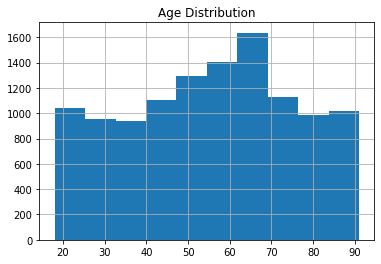

In [13]:
admissions_sample.age.hist()
plt.title('Age Distribution')

Text(0.5, 1.0, 'Gender Distribution')

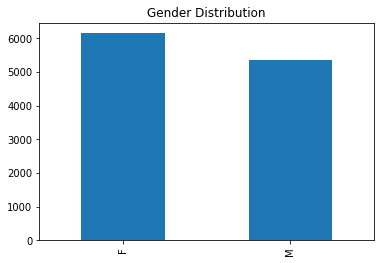

In [14]:
admissions_sample.gender.value_counts().plot(kind='bar')
plt.title('Gender Distribution')

Text(0.5, 1.0, 'Ethnicity Distribution')

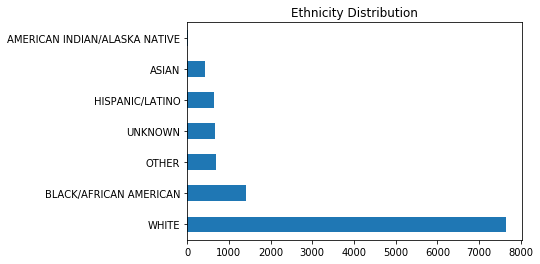

In [15]:
admissions_sample.ethnicity.value_counts().plot(kind='barh')
plt.title('Ethnicity Distribution')

In [16]:
print('Number of unique Patients: ', target_sample.subject_id.nunique())
print('\nSample Breakdown:')
print(target_sample.pos_subj.value_counts())

Number of unique Patients:  15000

Sample Breakdown:
0    13768
1     1232
Name: pos_subj, dtype: int64


Generate pickle file so we all work on the exact same data

In [19]:
admissions_sample.to_pickle('./data/admissions_sample.pkl')

In [ ]:
# admissions_sample = pd.read_pickle("admissions_sample.pkl")

In [ ]:
admissions_sample